In [6]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from typing import List
from sklearn.metrics import mean_squared_error

In [7]:
def dihedral_term(phi, n, phase, k=1):
    return k*(1+np.cos(n*phi - phase))

In [8]:
def V(phi: float, period: List[int], phases: List[float], force_const: List[float] = None ) -> float:

    if force_const is None:
        force_const = [1 for _ in period]

    assert len(period) == len(phases), "n and phase must have the same length"
    assert len(period) == len(force_const), "n and force_const must have the same length"

    dihedral_pot = 0
    for n, phase, k in zip(period, phases, force_const):
        dihedral_pot += dihedral_term(phi, n, phase, k)

    return dihedral_pot

In [ ]:
dihedral = "1_2_3_4" # fit a single torsion (for fitting multiple chemically equivalent torsions, see below)
seed_no = 4
fragment = 1

In [10]:
import numpy as np
from itertools import product

phases = [0, np.pi]
n_periods = 4

all_combinations = []
force_constants = [1]

# iterate over the number of periods and phases
for num_periods, num_phases in product(range(1, n_periods+1), repeat=2):  
    if num_periods >= num_phases: 

        # generate all combinations of phases for the current number of phases
        phase_combinations = product(phases, repeat=num_phases)
        for phase_combo in phase_combinations:
            if len(phase_combo) == num_periods and len(force_constants) == num_periods:
                all_combinations.append((list(range(1, num_periods + 1)), phase_combo, force_constants[:num_periods]))

        # update force_constants when the number of periods changes
        if num_periods > len(force_constants):
            force_constants.append(1)

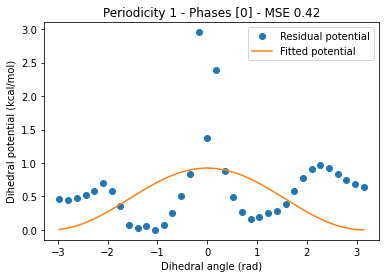

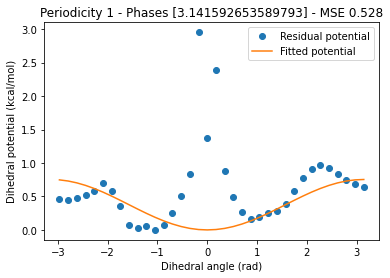

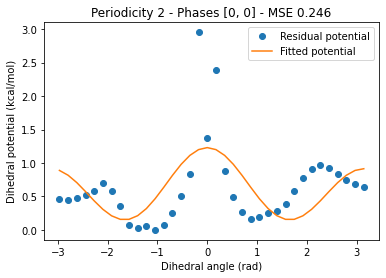

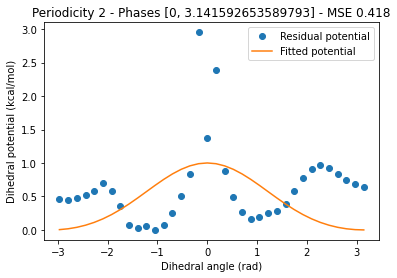

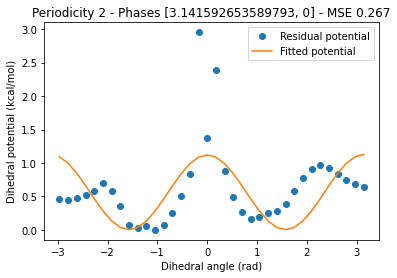

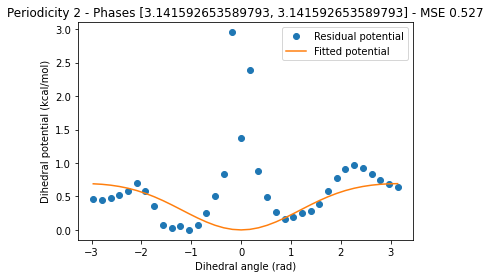

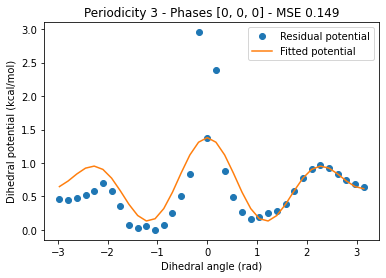

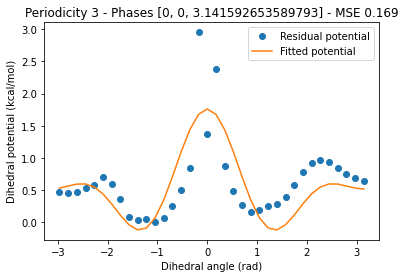

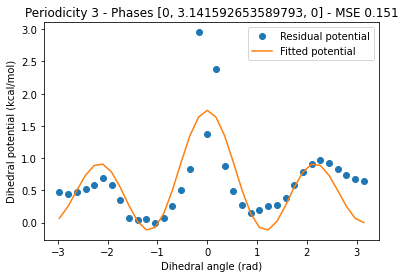

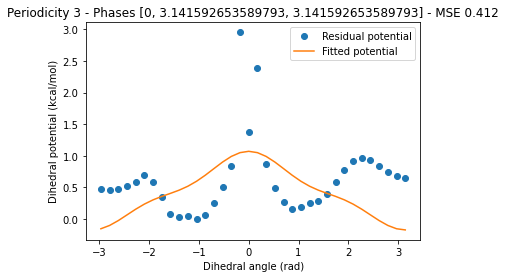

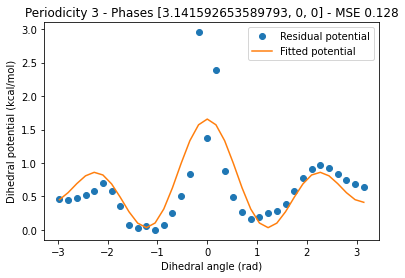

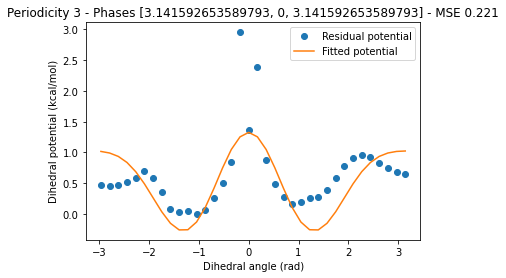

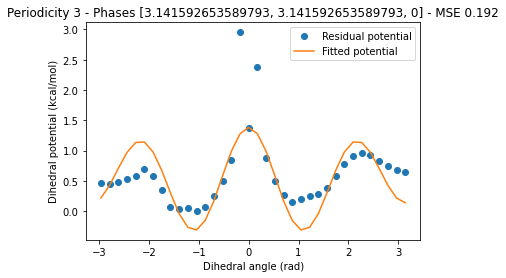

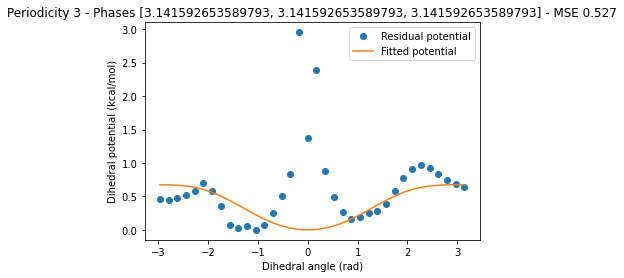

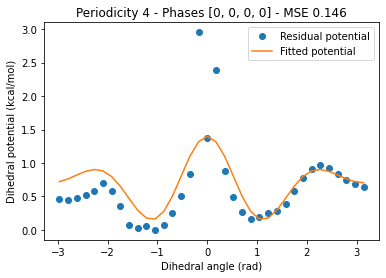

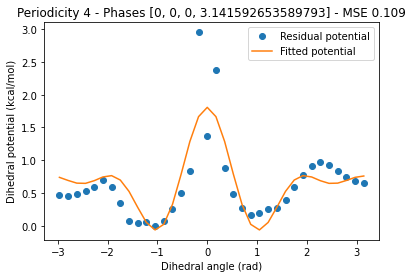

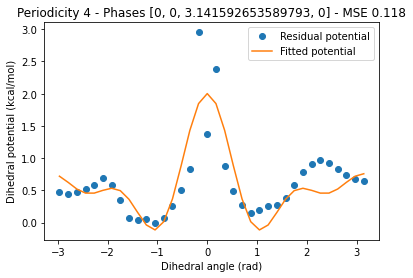

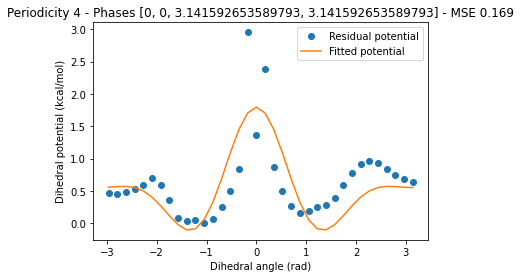

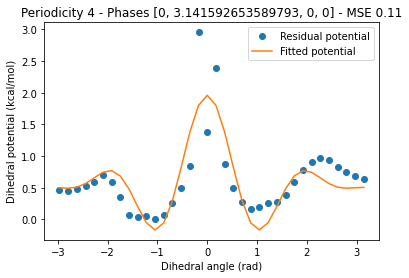

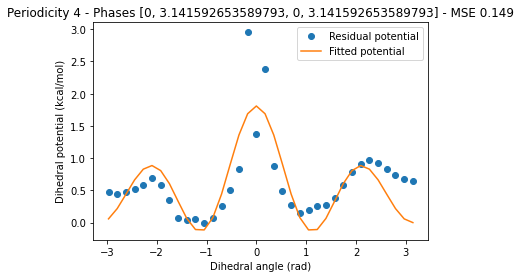

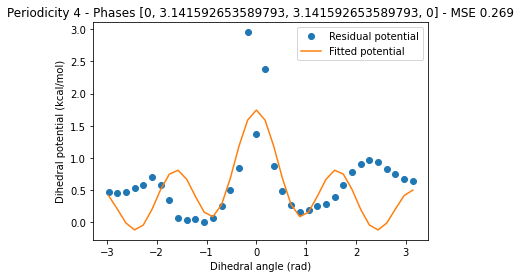

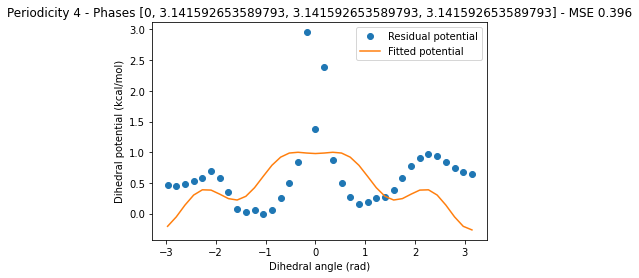

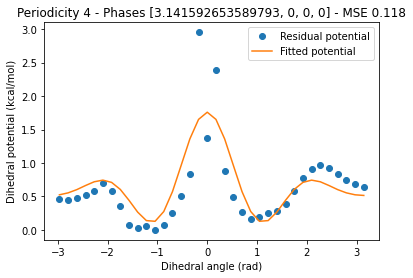

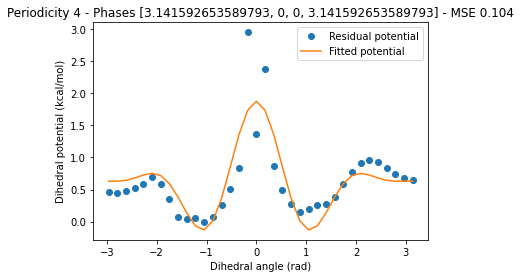

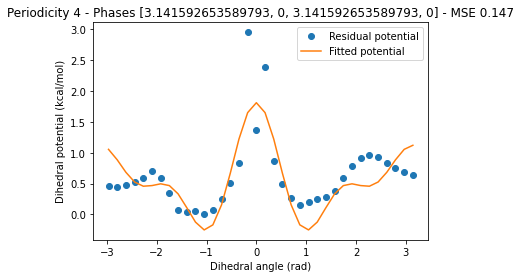

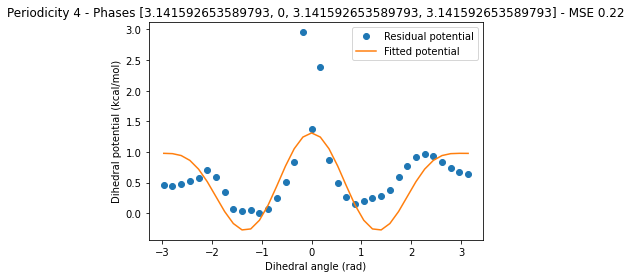

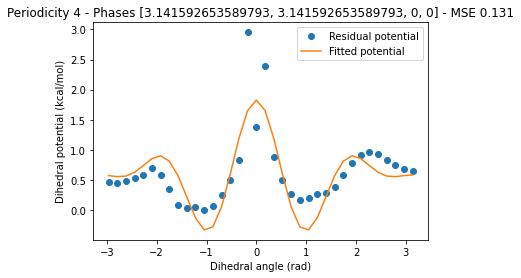

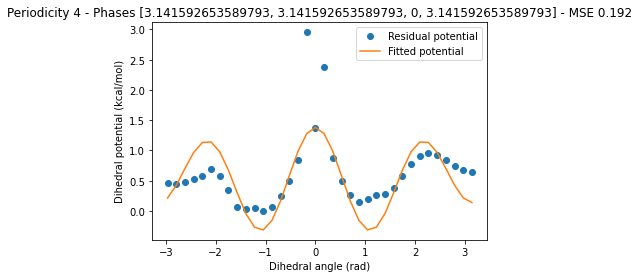

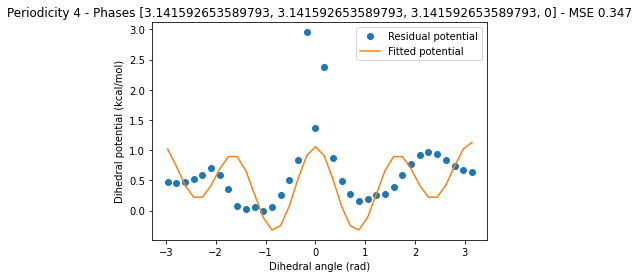

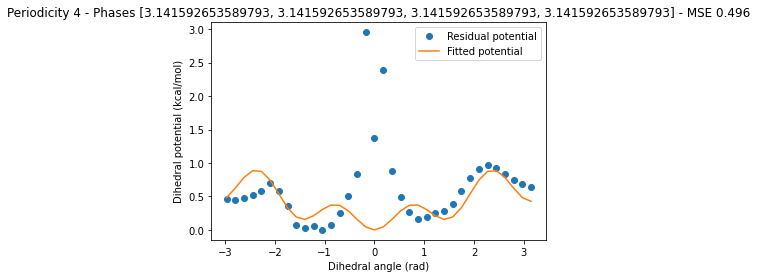

In [11]:
forward = np.arange(-180,190,10).tolist()
forward.remove(-180)  # will depend on the QM data 

mse_list = []
k_list = []

phi = []
for i in forward:
    phi.append(i*np.pi/180.0)

for combination in all_combinations:
    period =  combination[0]
    phases = combination[1]
    force_const = combination[2]

    # load the residual energy
    Vref = np.load('./profiles_torsions/individual_conformer_scans/fragment%s/torsion%s/qm-mm_torsion%s_seed%s.npy' % (fragment, dihedral, dihedral, seed_no))
    
    # fit torsion potential for all combinations of periods and phases
    b = np.asarray(Vref).reshape(-1, 1)
    a = np.zeros((len(phi), len(period)))
    for i, p in enumerate(phi):
        for j, n in enumerate(period):
            a[i, j] = dihedral_term(p, n, phases[j], 1) # force constant set to 1 because we are fitting it

    # solve linear system and obtain k
    k = np.linalg.inv(a.T @ a) @ a.T @ b
    k_list.append(k)

    mse = mean_squared_error(Vref, a@k)
    mse_list.append(mse)
    
    # plot all fitting solutions

    plt.plot(phi, Vref, 'o', label="Residual potential")
    plt.plot(phi, a @ k, label="Fitted potential")
    plt.title('Periodicity %s - Phases %s - MSE %s' % (combination[0][-1], list(combination[1]), round(mse,3)))
    plt.xlabel("Dihedral angle (rad)")
    plt.ylabel("Dihedral potential (kcal/mol)")
    plt.legend()
    
    plt.show()

In [12]:
min(mse_list)
min_index = mse_list.index(min(mse_list))

In [14]:
mse_list

[0.4204261728333844,
 0.5284755303439176,
 0.24631373327125583,
 0.4177641371206942,
 0.2670613670032012,
 0.5266757324013887,
 0.14895512940566139,
 0.16943908953515946,
 0.1508349704718092,
 0.41248839682535215,
 0.1275043937376301,
 0.2205293019631126,
 0.19235849305288444,
 0.5265528675024119,
 0.1464340966631885,
 0.10895831604584948,
 0.11840779203220042,
 0.16884855865605677,
 0.10973513247975937,
 0.14858147744328631,
 0.26928507935636176,
 0.3960479715610842,
 0.11827179083651213,
 0.10375281083336624,
 0.14666622361351184,
 0.2200637908515614,
 0.1305528052912768,
 0.19235595086899693,
 0.34652348957586715,
 0.4962431823947826]

In [ ]:
# desired_index = mse_list.index(1.5482819009185176) 
# a different fit other than that with the min MSE can be selected based on it MSE value

desired_index = mse_list.index(min(mse_list))

23

In [23]:
fitted_periods = all_combinations[desired_index][:-1][0]
fitted_phases = list(all_combinations[desired_index][:-1][1])  # Convert tuple to list

fitted_k = []
for i in k_list[desired_index]:
    fitted_k.append(i.tolist()[0])

print('original fitted k', fitted_k)
print('original fitted periods', fitted_periods)
print('original fitted phases', fitted_phases)

fitted_k = []

for i, k_val in enumerate(k_list[desired_index]):
    k_scalar = k_val.tolist()[0]

    # flip sign if negative and adjust phase
    if k_scalar < 0:
        k_scalar = -k_scalar
        # flip phase: 0 <-> 180 or pi <-> 0
        if fitted_phases[i] == 0:
            fitted_phases[i] = 3.141592653589793
        elif fitted_phases[i] == 3.141592653589793:
            fitted_phases[i] = 0

    fitted_k.append(k_scalar)

print('new fitted k', fitted_k)
print('new fitted periods', fitted_periods)
print('new fitted phases', fitted_phases)


original fitted k [-0.12034869649420327, 0.43640321713044394, 0.5014242310974617, -0.19221578171410886]
original fitted periods [1, 2, 3, 4]
original fitted phases [3.141592653589793, 0, 0, 3.141592653589793]
new fitted k [0.12034869649420327, 0.43640321713044394, 0.5014242310974617, 0.19221578171410886]
new fitted periods [1, 2, 3, 4]
new fitted phases [0, 0, 0, 0]


In [24]:
multiplicity = 1

for i in fitted_k:
    print(multiplicity*i)

0.12034869649420327
0.43640321713044394
0.5014242310974617
0.19221578171410886


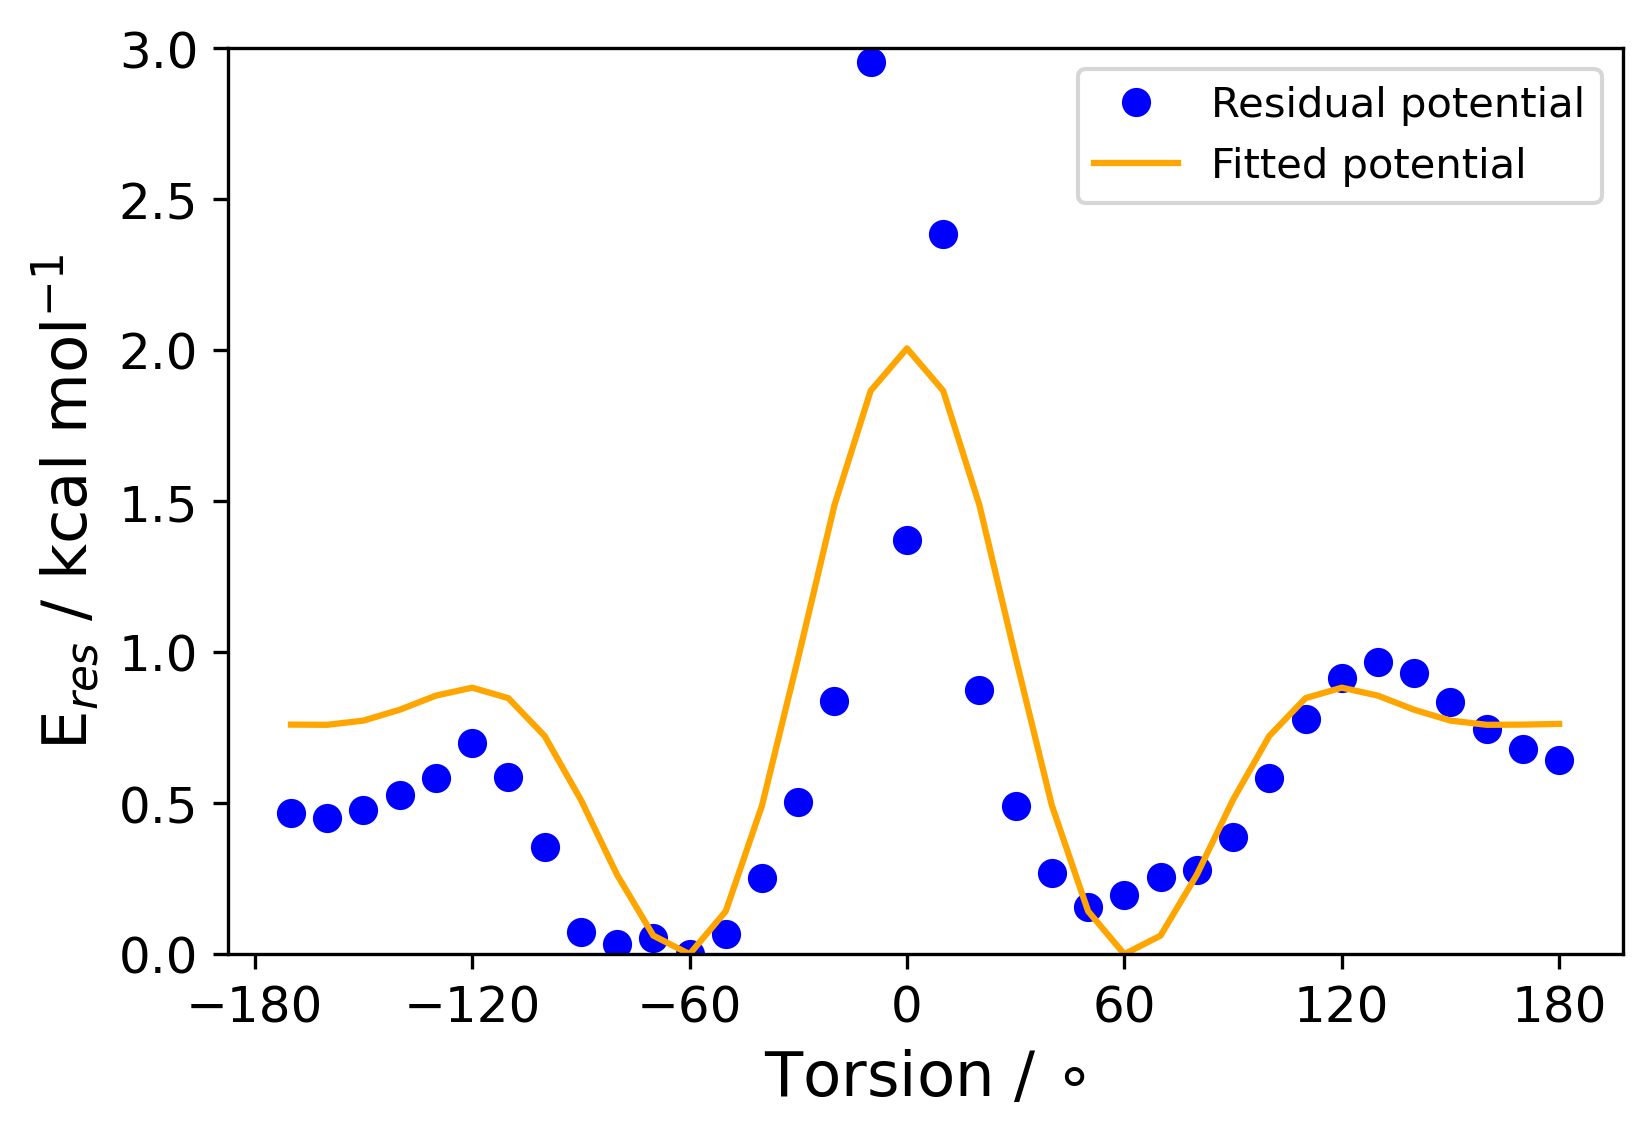

In [29]:
forward = np.arange(-170,190,10).tolist() # adjust according to missing values

period = fitted_periods
phases = fitted_phases
force_const = fitted_k

Vfit = [V(p, period, phases, force_const) for p in phi]

Vref = np.load('./profiles_torsions/individual_conformer_scans/fragment%s/torsion%s/qm-mm_torsion%s_seed%s.npy' % (fragment, dihedral, dihedral, seed_no))

plt.plot(forward, Vref, 'o', color='blue', label="Residual potential")
plt.plot(forward, Vfit - min(Vfit), color='orange', label="Fitted potential")

plt.xticks(range(-180, 181, 60), fontsize=12) 
plt.yticks(fontsize=12) 
plt.xlabel('Torsion / $\circ$', fontsize=15)
plt.ylabel('E$_{res}$ / kcal mol$^{-1}$', fontsize=15)
plt.ylim(0.0,3.0)
plt.rcParams['figure.dpi'] = 300
plt.legend()
plt.show()


### Fitting of multiple chemically equivalent torsions

In [ ]:
seed_no = 4
dihedral1 = "13_2_3_15"
dihedral2 = "14_2_3_15"


fragment1 = 5
fragment2 = 5

In [ ]:
Vref1 = np.load('./profiles_torsions/individual_conformer_scans/fragment%s/torsion%s/qm-mm_torsion%s_seed%s.npy' % (fragment1, dihedral1, dihedral1, seed_no))
Vref2 = np.load('./profiles_torsions/individual_conformer_scans/fragment%s/torsion%s/qm-mm_torsion%s_seed%s.npy' % (fragment2, dihedral2, dihedral2, seed_no))

In [ ]:
forward1 = np.arange(-180,190,10).tolist()
forward1.remove(-180) # adjust according to missing values

phi1 = []
for i in forward1:
    phi1.append(i*np.pi/180.0)


plt.plot(forward1, Vref1, 'o', label="Torsion %s from Fragment %s" %(dihedral1, fragment1))
plt.plot(forward1, Vref2, 'o', label="Torsion %s from Fragment %s" %(dihedral2, fragment2))


plt.xlabel('Torsion / $\circ$', fontsize=15)
plt.ylabel('E$_{res}$ / kcal mol$^{-1}$', fontsize=15)
plt.legend(loc='best')

plt.show()

In [ ]:
Vref_avg = (Vref1 + Vref2)/2

Vref_avg_norm = Vref_avg - np.min(Vref_avg)

forward = np.arange(-180,190,10).tolist()
forward.remove(-180) # adjust according to missing values


plt.plot(dihedral, Vref_avg_norm, 'o')
plt.xlabel('Torsion / $\circ$', fontsize=15)
plt.ylabel('E$_{res}$ / kcal mol$^{-1}$', fontsize=15)
plt.legend(loc='best')
plt.show()

In [ ]:
forward = np.arange(-180,190,10).tolist()
forward.remove(-180) # adjust according to missing values

mse_list = []
k_list = []

phi = []
for i in forward:
    phi.append(i*np.pi/180.0)

for combination in all_combinations:
    period =  combination[0]
    phases = combination[1]
    force_const = combination[2]

    Vref = Vref_avg_norm

    # Fit the dihedral potential to the reference potential
    b = np.asarray(Vref).reshape(-1, 1)
    a = np.zeros((len(phi), len(period)))
    for i, p in enumerate(phi):
        for j, n in enumerate(period):
            a[i, j] = dihedral_term(p, n, phases[j], 1) # force constant is set to 1 because we are fitting it

    # Solve the linear system
    k = np.linalg.inv(a.T @ a) @ a.T @ b
    k_list.append(k)


    mse = mean_squared_error(Vref, a@k)
    mse_list.append(mse)

    
    # Plot the dihedral potential
    plt.plot(phi, Vref, 'o', label="Residual potential")
    plt.plot(phi, a @ k, label="Fitted potential")
    plt.title('Periodicity %s - Phases %s - MSE %s' % (combination[0][-1], list(combination[1]), round(mse,3)))
    plt.xlabel("Dihedral angle (rad)")
    plt.ylabel("Dihedral potential (kcal/mol)")
    plt.legend()
    
    plt.show()

In [ ]:
min(mse_list)
min_index = mse_list.index(min(mse_list))

In [ ]:
mse_list

In [ ]:
# desired_index = mse_list.index(1.5482819009185176) 
# a different fit other than that with the min MSE can be selected based on it MSE value

desired_index = mse_list.index(min(mse_list))

In [ ]:
fitted_periods = all_combinations[desired_index][:-1][0]
fitted_phases = list(all_combinations[desired_index][:-1][1])  # Convert tuple to list

fitted_k = []
for i in k_list[desired_index]:
    fitted_k.append(i.tolist()[0])

print('original fitted k', fitted_k)
print('original fitted periods', fitted_periods)
print('original fitted phases', fitted_phases)

fitted_k = []

for i, k_val in enumerate(k_list[desired_index]):
    k_scalar = k_val.tolist()[0]

    # flip sign if negative and adjust phase
    if k_scalar < 0:
        k_scalar = -k_scalar
        # flip phase: 0 <-> 180 or pi <-> 0
        if fitted_phases[i] == 0:
            fitted_phases[i] = 3.141592653589793
        elif fitted_phases[i] == 3.141592653589793:
            fitted_phases[i] = 0

    fitted_k.append(k_scalar)

print('new fitted k', fitted_k)
print('new fitted periods', fitted_periods)
print('new fitted phases', fitted_phases)


In [ ]:
multiplicity = 1

for i in fitted_k:
    print(multiplicity*i)

In [ ]:
forward = np.arange(-170,190,10).tolist() # adjust according to missing values

period = fitted_periods
phases = fitted_phases
force_const = fitted_k

Vfit = [V(p, period, phases, force_const) for p in phi]

Vref = np.load('./profiles_torsions/individual_conformer_scans/fragment%s/torsion%s/qm-mm_torsion%s_seed%s.npy' % (fragment1, dihedral1, dihedral1, seed_no))

plt.plot(forward, Vref, 'o', color='blue', label="Residual potential")
plt.plot(forward, Vfit - min(Vfit), color='orange', label="Fitted potential")

plt.xticks(range(-180, 181, 60), fontsize=12) 
plt.yticks(fontsize=12) 
plt.xlabel('Torsion / $\circ$', fontsize=15)
plt.ylabel('E$_{res}$ / kcal mol$^{-1}$', fontsize=15)
plt.ylim(0.0,3.0)
plt.rcParams['figure.dpi'] = 300
plt.legend()
plt.show()
